In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o = []
mammo_f = []
label = []
project_folder = "../dataset/"
os.chdir(project_folder)
l = os.listdir()

In [4]:
def create_dataset(ls, o_img, f_img, lbl):
    for l in ls:
        if "_1_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(1)
        elif "_2_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(0)

In [5]:
os.chdir("./")
threads = []
chunk = 6
for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()

for i in threads:
    i.join()

In [6]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [7]:
def cnn_f(shape=(64, 64, 1)):
    model = Sequential([
        
        Conv2D(10, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
    
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(16, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(29, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.2),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [8]:
model_f = cnn_f()
model_f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 10)        100       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 10)       40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 10)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 16)        1456      
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 16)       6

In [9]:
learning_rate = 0.001
model_f.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [11]:
X_train_f, X_val_f, Y_train_f, Y_val_f = train_test_split(mammo_f_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
train_f = model_f.fit(X_train_f, Y_train_f,
                            batch_size = batch_size,
                            epochs = 200,
                            verbose = 1,
                            validation_data = (X_val_f, Y_val_f),
                            callbacks = [reduce_on_plateau])

Epoch 1/200
6/6 [==============================] - 5s 390ms/step - loss: 0.6637 - accuracy: 0.6410 - val_loss: 0.7120 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 158ms/step - loss: 0.6025 - accuracy: 0.6838 - val_loss: 0.7054 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 156ms/step - loss: 0.5397 - accuracy: 0.7265 - val_loss: 0.6925 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5364 - accuracy: 0.7265 - val_loss: 0.6806 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 151ms/step - loss: 0.4887 - accuracy: 0.7863 - val_loss: 0.6727 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 189ms/step - loss: 0.4964 - accuracy: 0.7607 - val_loss: 0.6554 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 166ms/step - loss: 0.4

Epoch 54/200
6/6 [==============================] - 1s 180ms/step - loss: 0.1213 - accuracy: 0.9573 - val_loss: 0.5530 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 55/200
6/6 [==============================] - 1s 152ms/step - loss: 0.1166 - accuracy: 0.9744 - val_loss: 0.5411 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 56/200
6/6 [==============================] - 1s 181ms/step - loss: 0.1144 - accuracy: 0.9744 - val_loss: 0.5457 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 57/200
6/6 [==============================] - 1s 162ms/step - loss: 0.1022 - accuracy: 0.9744 - val_loss: 0.5627 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 58/200
6/6 [==============================] - 1s 168ms/step - loss: 0.0955 - accuracy: 0.9744 - val_loss: 0.5780 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 59/200
6/6 [==============================] - 1s 166ms/step - loss: 0.1043 - accuracy: 0.9658 - val_loss: 0.5861 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 60/200
6/6 [==============================] - 1s 176ms/step - lo

Epoch 106/200
6/6 [==============================] - 1s 149ms/step - loss: 0.0682 - accuracy: 0.9829 - val_loss: 0.4314 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 107/200
6/6 [==============================] - 1s 147ms/step - loss: 0.0739 - accuracy: 0.9829 - val_loss: 0.4295 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 108/200
6/6 [==============================] - 1s 155ms/step - loss: 0.0818 - accuracy: 0.9915 - val_loss: 0.4281 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 109/200
6/6 [==============================] - 1s 145ms/step - loss: 0.0750 - accuracy: 0.9744 - val_loss: 0.4272 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 110/200
6/6 [==============================] - 1s 141ms/step - loss: 0.0746 - accuracy: 0.9829 - val_loss: 0.4268 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 111/200
6/6 [==============================] - 1s 155ms/step - loss: 0.0699 - accuracy: 0.9829 - val_loss: 0.4266 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 112/200
6/6 [=====================

6/6 [==============================] - 1s 156ms/step - loss: 0.0702 - accuracy: 0.9829 - val_loss: 0.4592 - val_accuracy: 0.7000 - lr: 1.0000e-09
Epoch 158/200
6/6 [==============================] - 1s 168ms/step - loss: 0.0727 - accuracy: 0.9829 - val_loss: 0.4598 - val_accuracy: 0.7000 - lr: 1.0000e-09
Epoch 159/200
6/6 [==============================] - 1s 162ms/step - loss: 0.0758 - accuracy: 0.9744 - val_loss: 0.4602 - val_accuracy: 0.7000 - lr: 1.0000e-09
Epoch 160/200
6/6 [==============================] - 1s 178ms/step - loss: 0.0685 - accuracy: 0.9829 - val_loss: 0.4606 - val_accuracy: 0.7000 - lr: 1.0000e-09
Epoch 161/200
6/6 [==============================] - 1s 160ms/step - loss: 0.0683 - accuracy: 0.9829 - val_loss: 0.4610 - val_accuracy: 0.7000 - lr: 1.0000e-09
Epoch 162/200
6/6 [==============================] - 1s 166ms/step - loss: 0.0758 - accuracy: 0.9829 - val_loss: 0.4610 - val_accuracy: 0.7000 - lr: 1.0000e-10
Epoch 163/200
6/6 [==============================] - 1

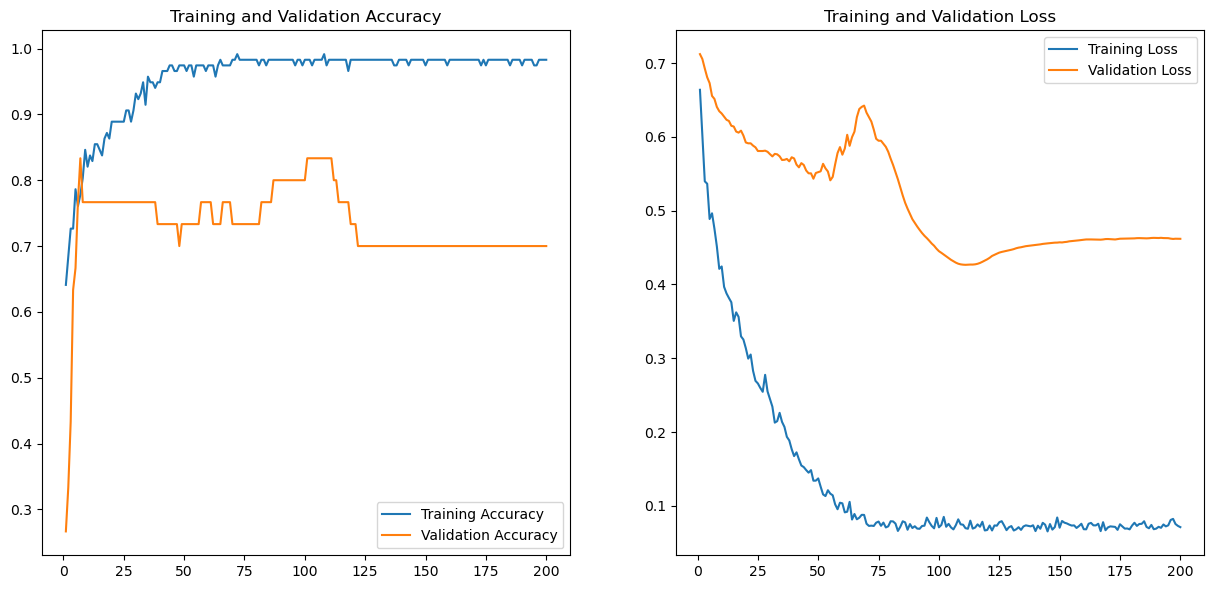

In [12]:
acc = train_f.history['accuracy']
val_acc = train_f.history['val_accuracy']
loss = train_f.history['loss']
val_loss = train_f.history['val_loss']
    
epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
    #Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
def cnn_f_aug(shape=(64, 64, 1)):
    model = Sequential([
        
        Conv2D(9, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
    
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(22, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(33, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.2),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [14]:
model_f_aug = cnn_f_aug()
model_f_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 9)         90        
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 9)        36        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64, 64, 9)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 9)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 22)        1804      
                                                                 
 batch_normalization_4 (Batc  (None, 31, 31, 22)      

In [15]:
learning_rate = 0.001
model_f_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_f = aug.flow(mammo_f_4d, label, batch_size = 30, subset = 'training')
aug_val_f = aug.flow(mammo_f_4d, label, batch_size = 30, subset = 'validation')

In [17]:
batch_size = 42
train_f_aug = model_f_aug.fit(aug_train_f,
                            batch_size = batch_size,
                            epochs = 200,
                            verbose = 1,
                            validation_data = aug_val_f,
                            callbacks = [reduce_on_plateau])

Epoch 1/200
4/4 [==============================] - 5s 607ms/step - loss: 0.8509 - accuracy: 0.4576 - val_loss: 0.7017 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 275ms/step - loss: 0.6675 - accuracy: 0.6356 - val_loss: 0.7004 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 266ms/step - loss: 0.6844 - accuracy: 0.6356 - val_loss: 0.6923 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5374 - accuracy: 0.7203 - val_loss: 0.6947 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5392 - accuracy: 0.7373 - val_loss: 0.6956 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5636 - accuracy: 0.7373 - val_loss: 0.6929 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 7/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5

4/4 [==============================] - 1s 254ms/step - loss: 0.5231 - accuracy: 0.7712 - val_loss: 0.7373 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4839 - accuracy: 0.7712 - val_loss: 0.7750 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5026 - accuracy: 0.7881 - val_loss: 0.7457 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4859 - accuracy: 0.7712 - val_loss: 0.7578 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4835 - accuracy: 0.7627 - val_loss: 0.7403 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 58/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4762 - accuracy: 0.7881 - val_loss: 0.7567 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/200
4/4 [==============================] - 1s 268m

4/4 [==============================] - 1s 259ms/step - loss: 0.4858 - accuracy: 0.7881 - val_loss: 0.7805 - val_accuracy: 0.5862 - lr: 1.0000e-12
Epoch 105/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4528 - accuracy: 0.7881 - val_loss: 0.7208 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 106/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4653 - accuracy: 0.7881 - val_loss: 0.7407 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 107/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4658 - accuracy: 0.7966 - val_loss: 0.7978 - val_accuracy: 0.6207 - lr: 1.0000e-12
Epoch 108/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5007 - accuracy: 0.7627 - val_loss: 0.7691 - val_accuracy: 0.6552 - lr: 1.0000e-13
Epoch 109/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4995 - accuracy: 0.7712 - val_loss: 0.7411 - val_accuracy: 0.6207 - lr: 1.0000e-13
Epoch 110/200
4/4 [==============================] - 1

4/4 [==============================] - 1s 298ms/step - loss: 0.4641 - accuracy: 0.7797 - val_loss: 0.8117 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 156/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4722 - accuracy: 0.7966 - val_loss: 0.7463 - val_accuracy: 0.5862 - lr: 1.0000e-17
Epoch 157/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4950 - accuracy: 0.7881 - val_loss: 0.7692 - val_accuracy: 0.5517 - lr: 1.0000e-17
Epoch 158/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4574 - accuracy: 0.8136 - val_loss: 0.7173 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 159/200
4/4 [==============================] - 1s 348ms/step - loss: 0.4802 - accuracy: 0.7966 - val_loss: 0.7625 - val_accuracy: 0.5517 - lr: 1.0000e-18
Epoch 160/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4751 - accuracy: 0.7712 - val_loss: 0.8465 - val_accuracy: 0.5862 - lr: 1.0000e-18
Epoch 161/200
4/4 [==============================] - 1

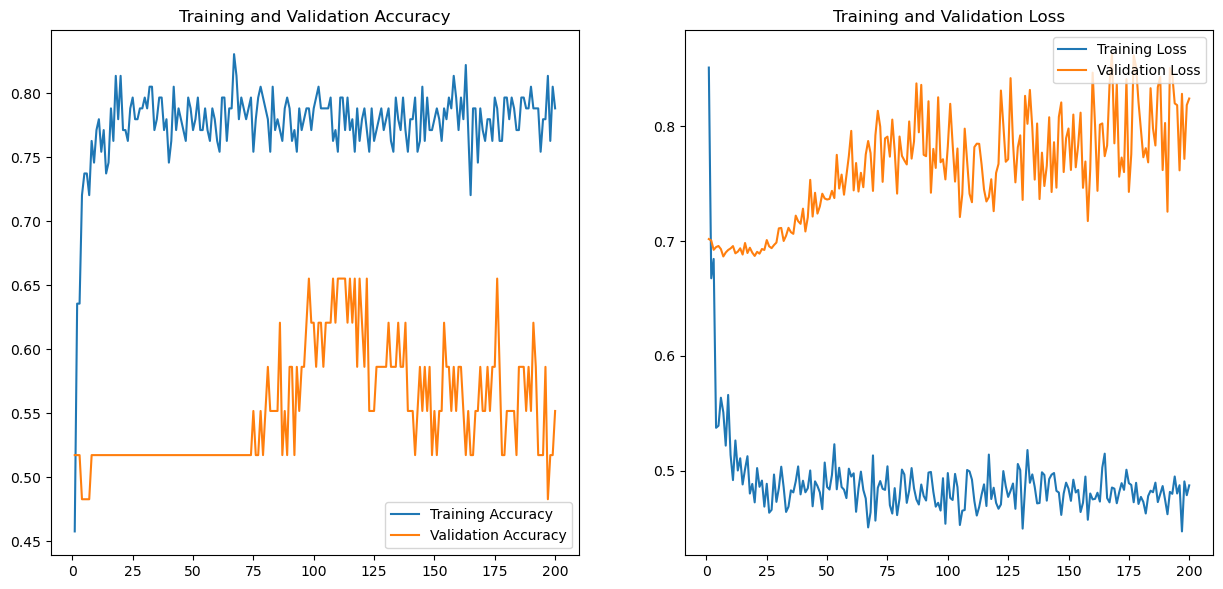

In [18]:
acc = train_f_aug.history['accuracy']
val_acc = train_f_aug.history['val_accuracy']
loss = train_f_aug.history['loss']
val_loss = train_f_aug.history['val_loss']
    
epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
    #Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
acc_f = []
acc_f_aug = []
for i in range(10):
    
    _, val_acc = model_f.evaluate(X_val_f, Y_val_f, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_f.append(val_acc)

    _, val_acc = model_f_aug.evaluate(aug_val_f, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_f_aug.append(val_acc)

Validation accuracy: 0.700
Validation accuracy: 0.552
Validation accuracy: 0.700
Validation accuracy: 0.517
Validation accuracy: 0.700
Validation accuracy: 0.552
Validation accuracy: 0.700
Validation accuracy: 0.586
Validation accuracy: 0.700
Validation accuracy: 0.517
Validation accuracy: 0.700
Validation accuracy: 0.586
Validation accuracy: 0.700
Validation accuracy: 0.483
Validation accuracy: 0.700
Validation accuracy: 0.586
Validation accuracy: 0.700
Validation accuracy: 0.517
Validation accuracy: 0.700
Validation accuracy: 0.552


In [20]:
media_f = np.mean(acc_f)
std_f = np.std(acc_f)
print(media_f)
print(std_f)

0.699999988079071
0.0


In [21]:
media_f_aug = np.mean(acc_f_aug)
std_f_aug = np.std(acc_f_aug)
print(media_f_aug)
print(std_f_aug)

0.5448275834321976
0.033786078066921375


In [22]:
mammo_o_t, mammo_f_t, label_t = [], [], []
data_folder_t = "../test_dataset/"
os.chdir(data_folder_t)
l_t = os.listdir()

In [23]:
def create_dataset_t(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder_t, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder_t, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [24]:
os.chdir("./")
threads = []
chunk = 6

for i in range(10):
    t = thr.Thread(target = create_dataset_t, args = (l_t[i*chunk : (i+1)*chunk], mammo_o_t, mammo_f_t, label_t))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [25]:
eng.quit()

In [26]:
mammo_o_t = np.asarray(mammo_o_t, dtype = 'float32')/255.
mammo_f_t = np.asarray(mammo_f_t, dtype = 'float32')/255.
label_t = np.asarray(label_t)
mammo_o_4d_t = np.reshape(mammo_o_t, (30, 125, 125, 1))
print(mammo_o_4d_t.shape)
mammo_f_4d_t = np.reshape(mammo_f_t, (30, 64, 64, 1))
print(mammo_f_4d_t.shape)

(30, 125, 125, 1)
(30, 64, 64, 1)


In [27]:
if media_f > media_f_aug:
    test_loss, test_acc = model_f.evaluate(mammo_f_4d_t, label_t)
    preds_test = model_f.predict(mammo_f_4d_t, verbose=1)
    fpr, tpr, _ = roc_curve(label_t, preds_test)
    roc_auc = auc(fpr, tpr)

    print('\n Test accuracy = %.3f'% (test_acc))
    print('\n AUC = %.3f'% (roc_auc))
else:
    test_loss, test_acc = model_f_aug.evaluate(mammo_f_4d_t, label_t)
    preds_test = model_f_aug.predict(mammo_f_4d_t, verbose=1)
    fpr, tpr, _ = roc_curve(label_t, preds_test)
    roc_auc = auc(fpr, tpr)
    
    print('\n Test accuracy = %.3f'% (test_acc))
    print('\n AUC = %.3f'% (roc_auc))

1/1 [==============================] - 1s 796ms/step

 Test accuracy = 0.633

 AUC = 0.644
